## Mixed-element Meshing - Toy Problem

This workflow provides a testbed for testing features of mixed-element mesh wotkflow. The objects of river tree and huc boundary are a created to mimic what we get from NHDPlus. This example tests the case of two rivers, which is rare but still needs to be considered to make the workflow general

In [1]:
## Importing all the package needed to run teh watershed workflow

import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import copy

In [2]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)
crs=None

In [3]:
## NHDPlus input type objects

# creating watershed polygon
ws1= shapely.geometry.Polygon(100*np.array([[0,0],[1,0],[2,0],[3,0],[4,0],[4,1],[4,2],[4,3],[4,4],[3,4.5],[2,5],[1,4.5], [0,4], [0,3], [0,2] ,[0,1]], 'd'))

# creating reaches miminc NHDPlus flowlines
reach1=shapely.geometry.LineString([(200,200),(200,0)])
reach2=shapely.geometry.LineString([ (50,300), (100,300), (100,200),(200,200)])
reach3=shapely.geometry.LineString([ (350,400),(350,300),(300,300),(300,200),(200,200)])
reach4=shapely.geometry.LineString([(100,400), (200,300)])
reaches=[reach1, reach2, reach3, reach4]

In [4]:
# creating watershed_workflow.split_hucs.SplitHUCs object for demo watershed
my_hucs=[ws1]
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

In [5]:
rivers = watershed_workflow.construct_rivers(watershed,reaches, method='geometry')

# adding relevant properties
for river in rivers:
    for i, node in enumerate(river.preOrder()):
        node.properties['HydrologicSequence']=i


rivers_orig=[river.deep_copy() for river in rivers] # mimicking the original
watershed_orig=copy.deepcopy(watershed) # keeping the original

# simplify the geometry for a "nicer" discrete object
watershed_workflow.simplify(watershed, rivers, simplify_rivers=10,
                            snap_rivers=True, cut_intersections=True)

# for plotting purpose
rivers_simplified=[river.deep_copy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2023-02-21 21:36:19,827 - root - INFO: 
2023-02-21 21:36:19,828 - root - INFO: Constructing river network
2023-02-21 21:36:19,828 - root - INFO: ------------------------------
2023-02-21 21:36:19,828 - root - INFO: Generating the river tree
2023-02-21 21:36:19,829 - root - INFO:  ... generated 2 rivers
2023-02-21 21:36:19,830 - root - INFO: 
2023-02-21 21:36:19,830 - root - INFO: Simplifying
2023-02-21 21:36:19,830 - root - INFO: ------------------------------
2023-02-21 21:36:19,830 - root - INFO: Simplifying rivers
2023-02-21 21:36:19,831 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2023-02-21 21:36:19,832 - root - INFO:   snapping polygon segment boundaries to river endpoints
2023-02-21 21:36:19,833 - root - INFO:   snapping river endpoints to the polygon
2023-02-21 21:36:19,836 - root - INFO:   cutting at crossings
2023-02-21 21:36:19,836 - root - INFO: intersection found
2023-02-21 21:36:19,838 - root - INFO:   - cutting reach at external boundary of HUCs:
2023-

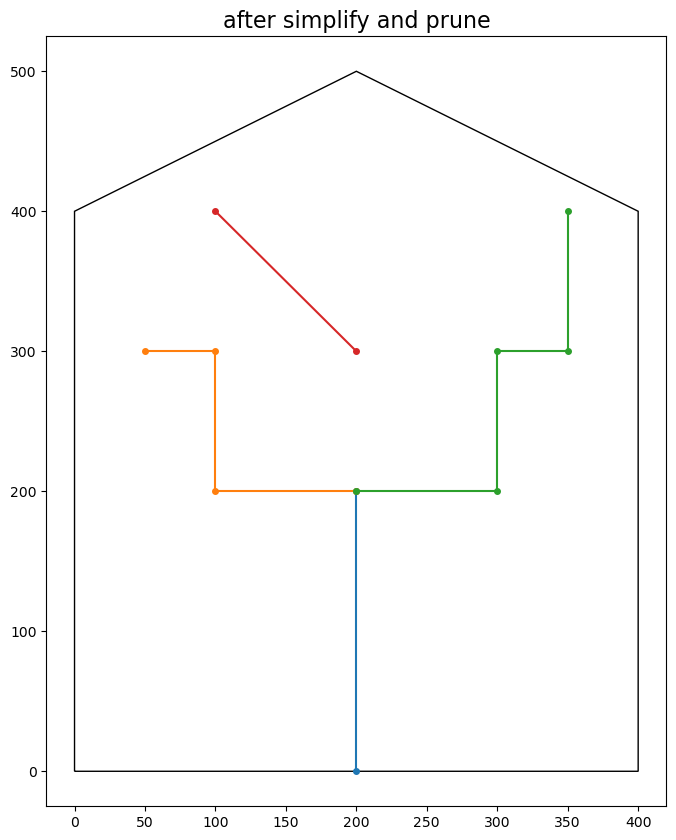

In [36]:
# quick glance at the problem
plt.rcParams['figure.figsize'] = [8, 10]

fig, axs = plt.subplots(1,1)

watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs)
axs.set_title('after simplify and prune',fontsize=16)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs.plot(x,y,'-o',markersize=4)
   

In [7]:
# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[0,25,100,50]) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=14, treat_collinearity=True)

2023-02-21 21:39:15,620 - root - INFO: trying to refine huc segment: 0
2023-02-21 21:39:15,621 - root - INFO: original huc segment 0 intersect huc segment 0 as <class 'shapely.geometry.multilinestring.MultiLineString'>
2023-02-21 21:39:15,621 - root - INFO: did not find corresponding huc.segment in original, doing simple interpolation
2023-02-21 21:39:15,623 - root - INFO: trying to refine huc segment: 1
2023-02-21 21:39:15,624 - root - INFO: original huc segment 0 intersect huc segment 1 as <class 'shapely.geometry.collection.GeometryCollection'>
2023-02-21 21:39:15,625 - root - INFO: for huc segment 1, found original huc segment 0
/Users/7s2/Softwares/watershed_workflow_main/watershed-workflow/watershed_workflow/densification.py:322: RuntimeWarning: divide by zero encountered in double_scalars
  m = (p2[1] - p0[1]) / (p2[0] - p0[0])
2023-02-21 21:39:15,630 - root - INFO:   river min seg length: 12.500000000300012
2023-02-21 21:39:15,631 - root - INFO:   river median seg length: 12.67

In [8]:
# finding the outlet
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[0])

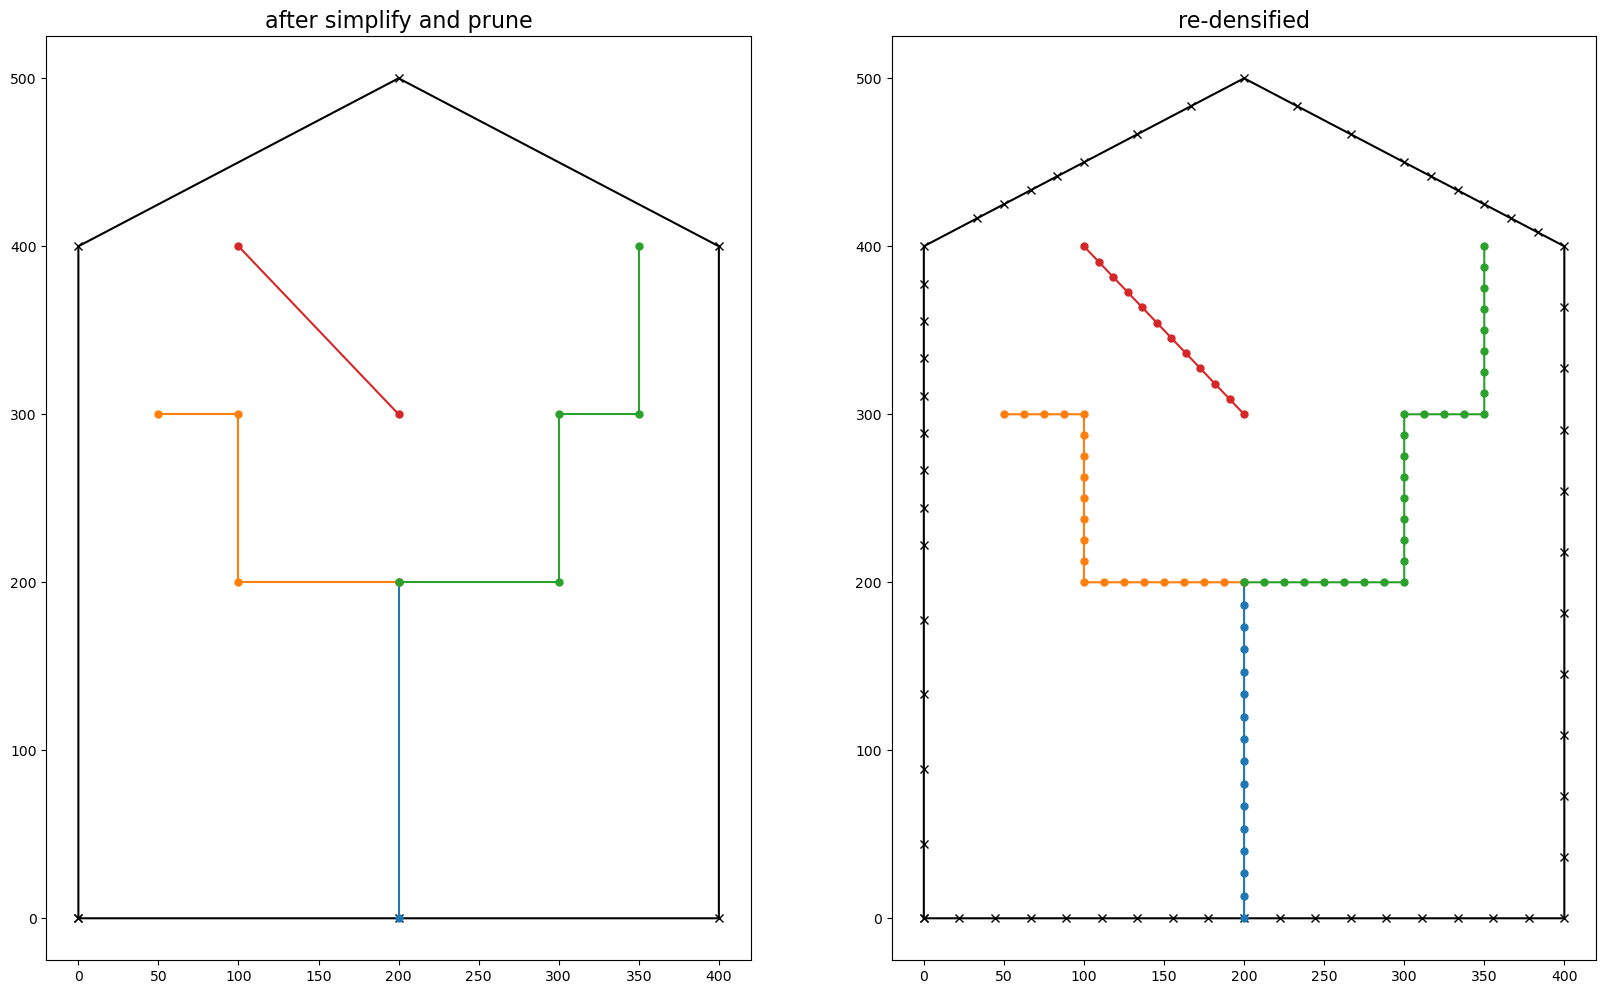

In [9]:
# plotting results
plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(1,2)

axs[0].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('after simplify and prune',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('re-densified',fontsize=16)
axs[1].plot()

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy
        axs[1].plot(x,y,'-o',markersize=5)

# Meshing

2023-02-21 21:41:13,780 - root - INFO: creating river corridor polygon
2023-02-21 21:41:13,780 - root - INFO: river min seg length: 12.500000000300012
2023-02-21 21:41:13,780 - root - INFO: merging points closer than this distance along the river corridor: 4.5000000003000125
2023-02-21 21:41:13,782 - root - INFO: defining river-mesh topology (quad elements)
2023-02-21 21:41:13,784 - root - INFO: setting width of quad elements based on StreamOrder
2023-02-21 21:41:13,786 - root - INFO: creating river corridor polygon
2023-02-21 21:41:13,786 - root - INFO: river min seg length: 12.856486930664465
2023-02-21 21:41:13,787 - root - INFO: merging points closer than this distance along the river corridor: 4.856486930664465
2023-02-21 21:41:13,787 - root - INFO: defining river-mesh topology (quad elements)
2023-02-21 21:41:13,788 - root - INFO: setting width of quad elements based on StreamOrder
2023-02-21 21:41:13,789 - root - INFO:   adjusting HUC boundary to include the river outlet segment

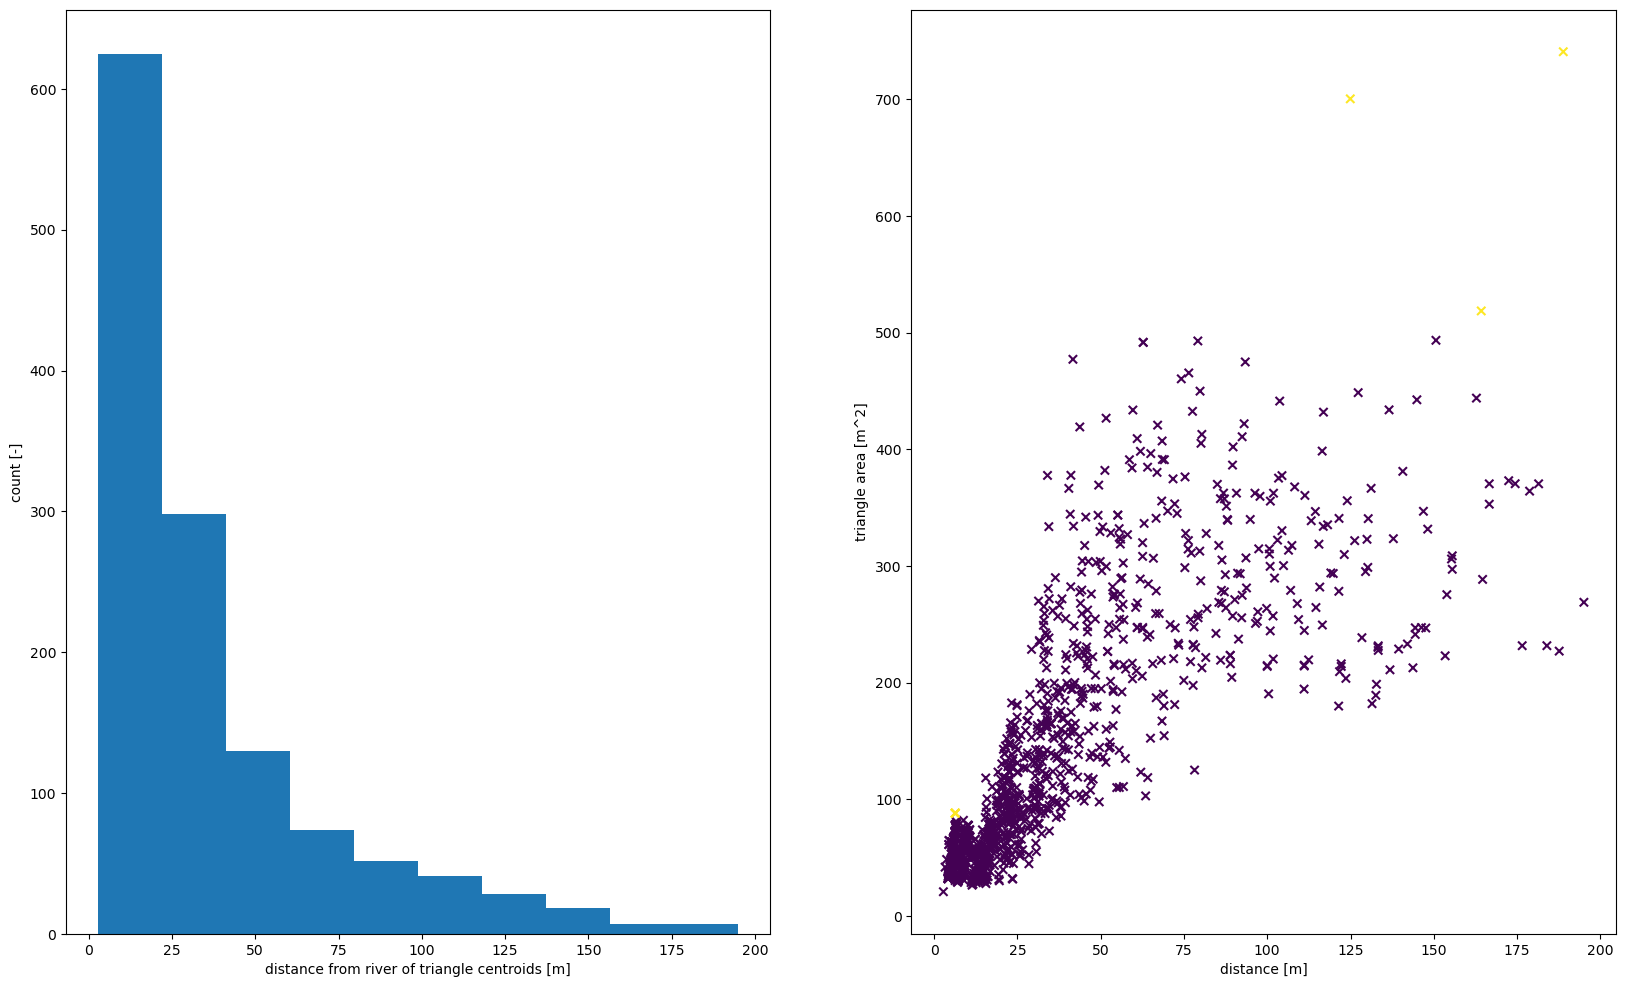

In [10]:
## Triangulation
refine_d0 = 12
refine_d1 = 18
refine_A0 = 82
refine_A1 = 500
d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width) or integer
widths=5

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True)

In [11]:
# providing elevations to each point of the mesh (real case this would come from DEMs)
points3=np.zeros((len(mesh_points2),3))
points3[:,:2]=mesh_points2
points3[:,2]=9+abs(mesh_points2[:,0]-200)/800+mesh_points2[:,1]/500 # gradient towards the outlet 

In [12]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(points3.copy(), conn_list)

In [13]:
# depressing river corridor
def condition_river_mesh(m2, river, depress_by):
    m2_copy=copy.deepcopy(m2)
    for node in river.preOrder():
        for i, elem in enumerate(node.elements):
            for j in range(len(elem)):
                m2.coords[elem[j]][2]=m2_copy.coords[elem[j]][2]-depress_by

In [14]:
# adding depressions for the river
for river in rivers:
    condition_river_mesh(m2, river, 1)

kwargs =  {'linewidth': 0.8, 'cmap': <matplotlib.colors.ListedColormap object at 0x284b29720>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x2868f1420>, 'edgecolor': 'k'}
setting face color =  [9.24907408 9.49506612 9.28796258 ... 8.85113613 8.88068137 8.90530283]


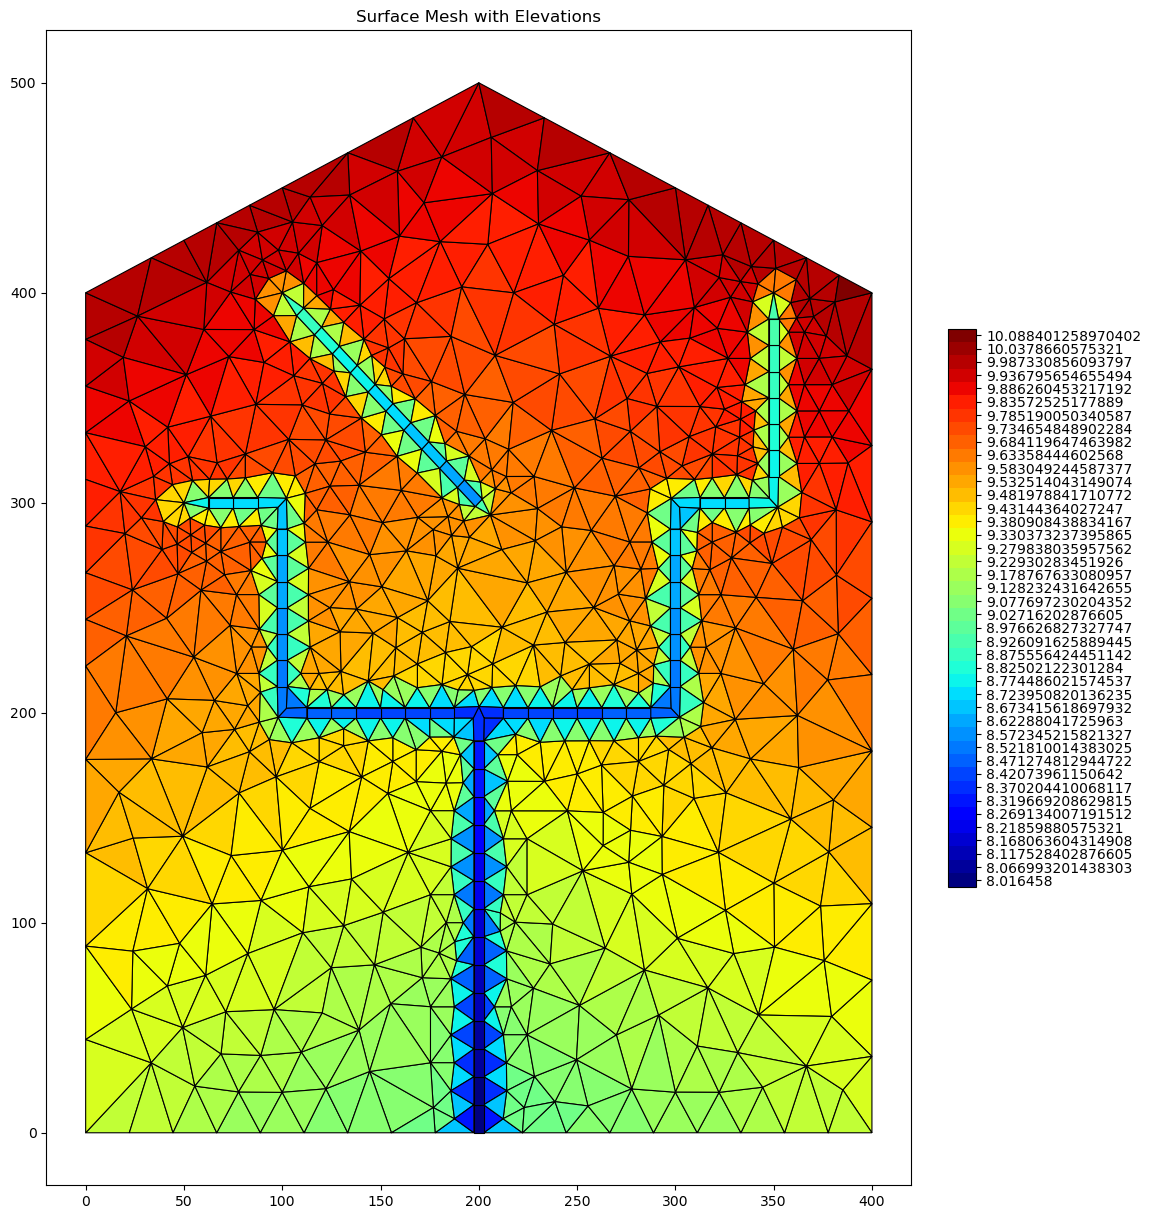

In [15]:
# plotting surface mesh with elevations
plt.rcParams['figure.figsize'] = [12, 15]
crs=None
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.8 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k',facecolor='color')

watershed_workflow.colors.colorbar_index(ncolors=len(legend_values), cmap=cmap, labels = labels) 
plt.title('Surface Mesh with Elevations')
plt.show()

### Mesh Extrusion

In [16]:
## **** Creating a 3D mesh

# this is oversimplified case where we wille xtrude this mesh in 3D with 10 layers of prescribed thicknesses

total_thickness = 10
dzs=[0.1,0.2, 0.2, 0.25,0.25,0.25,0.25,1,1.25,1.25,2,3]
print(sum(dzs))
assert(sum(dzs)==total_thickness)

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

depth = 0
for dz in dzs:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1000)
  
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2023-02-21 21:43:12,528 - root - INFO: Cell summary:
2023-02-21 21:43:12,528 - root - INFO: ------------------------------------------------------------
2023-02-21 21:43:12,529 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2023-02-21 21:43:12,529 - root - INFO: ------------------------------------------------------------
2023-02-21 21:43:12,530 - root - INFO:  00 	| 00 	| 1000 	|   0.100000 	|   0.000000
2023-02-21 21:43:12,530 - root - INFO:  01 	| 01 	| 1000 	|   0.200000 	|   0.100000
2023-02-21 21:43:12,530 - root - INFO:  02 	| 02 	| 1000 	|   0.200000 	|   0.300000
2023-02-21 21:43:12,530 - root - INFO:  03 	| 03 	| 1000 	|   0.250000 	|   0.500000
2023-02-21 21:43:12,531 - root - INFO:  04 	| 04 	| 1000 	|   0.250000 	|   0.750000
2023-02-21 21:43:12,531 - root - INFO:  05 	| 05 	| 1000 	|   0.250000 	|   1.000000
2023-02-21 21:43:12,531 - root - INFO:  06 	| 06 	| 1000 	|   0.250000 	|   1.250000
2023-02-21 21:43:12,531 - root - INFO:  07 	| 07 	| 1000 	|   1.000000 	|   1.5

10.0


In [51]:
# # extrude
# m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2,layer_types, layer_data, 
#                                             layer_ncells, layer_mat_ids)

# # saving mesh as exodus file
# m3.write_exodus('demo_mixed_element_mesh.exo')